In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report

import torch
from torch import Tensor
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

from models.simple_model_2 import Model_2
from dataset.loader import HDF5Dataset


In [2]:
# source: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
CUDA_LAUNCH_BLOCKING = 1


 ## Initialize some variables

In [3]:
dataset_dir = "/scratch/guszarzmo/lt2326_labs/lab1/data"
model_dir = "/scratch/guszarzmo/lt2326_labs/lab1/checkpoints"


In [4]:
# Variable changed by user
checkpoint = "m2_1710_00h0213.pt"
use_cpu = False  # set to True if you want to use cpu
prefered_device = None  # gpu id


  ## Selecte device

In [5]:
# Select cuda device based on the free memory
from utils.gpu_cuda_helper import select_device

if use_cpu:
    device = torch.device("cpu")
    print(f"\ndevice selected: {device}")

elif prefered_device:
    device = select_device(prefered_device)
    print(f"\ndevice selected: {device}")

else:
    device = select_device(-1)


 cuda id   Memory usage  
    0         12.35%     
    1          0.02%     
    2          0.02%     
    3          0.02%     

device selected: cuda:1


 ## Initialize dataset and dataloader

In [6]:

pin_memory = device.type == "cuda"
kwargs = dict(shuffle=False, num_workers=4, pin_memory=pin_memory)

test_ds_path = str(Path(dataset_dir) / "train.h5")
test_ds = HDF5Dataset(test_ds_path)
test_iter = DataLoader(test_ds, batch_size=1, **kwargs)


 ## Model loading

In [7]:
model = Model_2().to(device)

load_path = Path(model_dir) / "model2" / checkpoint
model_data = torch.load(load_path, map_location=torch.device("cpu"))
model_state_dict = model_data["model_state_dict"]

model.load_state_dict(model_state_dict)


<All keys matched successfully>

 ## Testing

In [8]:
transform = transforms.Normalize(*test_ds.mean_stddev)  # normalization
criterion = nn.CrossEntropyLoss().to(device)
class_names = ["n-char", "is_chinese", "ignore", "char"]

model.eval()
test_pb = tqdm(total=len(test_ds), unit="image")  # progress bar
losses = []

record_steps = []
f1_scores = []
f1_score_char = []

precisions = []
precisions_char = []

recalls = []
recalls_char = []

images_gt = []
labels_all = []
predections = []
for step, (images, labels) in enumerate(test_iter):
    test_pb.set_description(f"Step: {step:<3d}")
    images_tr = transform(images.to(device))  # type: Tensor
    labels = labels.to(device)  # type: Tensor
    with torch.no_grad():
        out = model(images_tr)  # type: Tensor
        loss = criterion(out, labels)

    losses.append(loss.item())

    probs = torch.log_softmax(out, dim=1)
    _, preds = torch.max(probs, dim=1)

    target_names = [
        class_names[i] for i in range(4)
        if (labels == i).any() or (preds == i).any()
    ]
    scores = classification_report(labels.detach().cpu().view(-1),
                                   preds.detach().cpu().view(-1),
                                   target_names=target_names,
                                   output_dict=True,
                                   zero_division=0)

    f1_scores.append(scores["macro avg"]["f1-score"])
    precisions.append(scores["macro avg"]["precision"])
    recalls.append(scores["macro avg"]["recall"])

    if "char" in scores:
        f1_score_char.append(scores["macro avg"]["f1-score"])
        precisions.append(scores["macro avg"]["precision"])
        recalls.append(scores["macro avg"]["recall"])
    
    images_gt.append(images.cpu().detach().numpy())
    labels_all.append(labels.cpu().detach().numpy())
    predections.append(preds.cpu().detach().numpy())

    test_pb.update(1)


  0%|          | 0/700 [00:00<?, ?image/s]

 ## Testing stats

#### Overall metrics

In [9]:
print(
    f"f1 score:  {np.array(f1_scores).mean(): .3f} \u00B1 {np.array(f1_scores).std(): .3f}"  # noqa: E501
)

print(
    f"Precision: {np.array(precisions).mean(): .3f} \u00B1 {np.array(precisions).std(): .3f}"  # noqa: E501
)

print(
    f"Recall:    {np.array(recalls).mean(): .3f} \u00B1 {np.array(recalls).std(): .3f}"  # noqa: E501
)


f1 score:   0.740 ±  0.117
Precision:  0.705 ±  0.118
Recall:     0.714 ±  0.113


#### Bonus part

In [10]:
print(
    f"f1 score:  {np.array(f1_score_char).mean(): .3f} \u00B1 {np.array(f1_score_char).std(): .3f}"  # noqa: E501
)

print(
    f"Precision: {np.array(precisions_char).mean(): .3f} \u00B1 {np.array(precisions_char).std(): .3f}"  # noqa: E501
)

print(
    f"Recall:    {np.array(recalls_char).mean(): .3f} \u00B1 {np.array(recalls_char).std(): .3f}"  # noqa: E501
)


f1 score:   0.630 ±  0.045
Precision:  nan ±  nan
Recall:     nan ±  nan


/tmp/ipykernel_3546589/1566656382.py:6: RuntimeWarning: Mean of empty slice.
  f"Precision: {np.array(precisions_char).mean(): .3f} \u00B1 {np.array(precisions_char).std(): .3f}"  # noqa: E501
/home/guszarzmo@GU.GU.SE/.virtualenvs/LT2326-labs/lib64/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/guszarzmo@GU.GU.SE/.virtualenvs/LT2326-labs/lib64/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/guszarzmo@GU.GU.SE/.virtualenvs/LT2326-labs/lib64/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/guszarzmo@GU.GU.SE/.virtualenvs/LT2326-labs/lib64/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encounter

In [11]:
# save images, labels ground truth and predictions
np.save("data/images_model_2.npy", np.array(images_gt))
np.save ("data/labels_model_2.npy", np.array(labels_all))
np.save ("data/preds_model_2.npy", np.array(predections))
np.save("data/f1_model_2.npy", np.array(f1_scores))

## Images superimposing

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

# load images, label grounf truth, model_1 predections and f1 score
images_gt = np.load("data/images_model_2.npy")
labels_all = np.load ("data/labels_model_2.npy")
predections = np.load ("data/preds_model_2.npy")
f1_scores_np = np.load ("data/f1_model_2.npy")


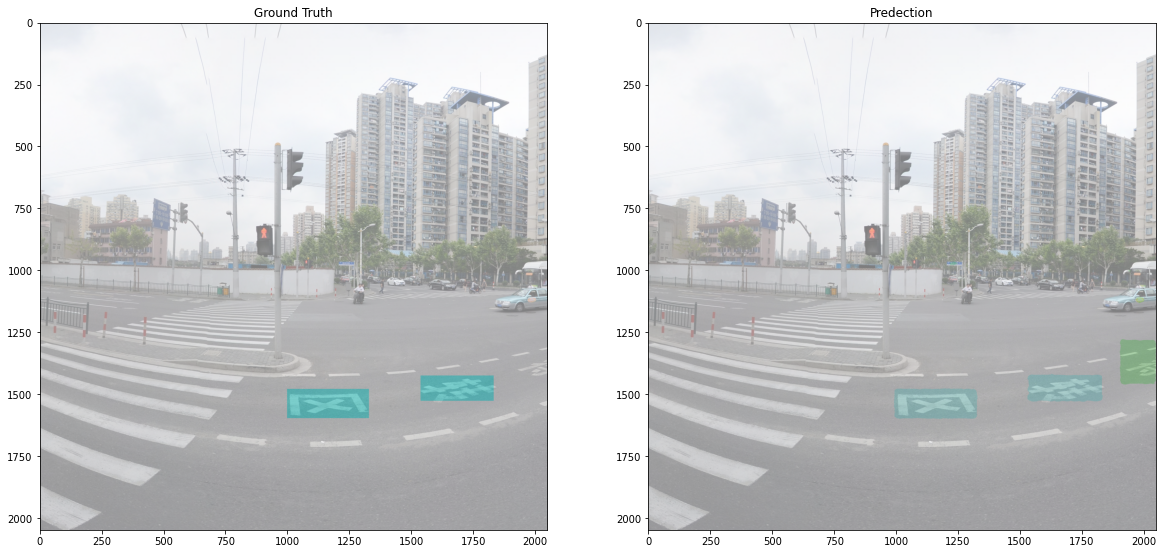

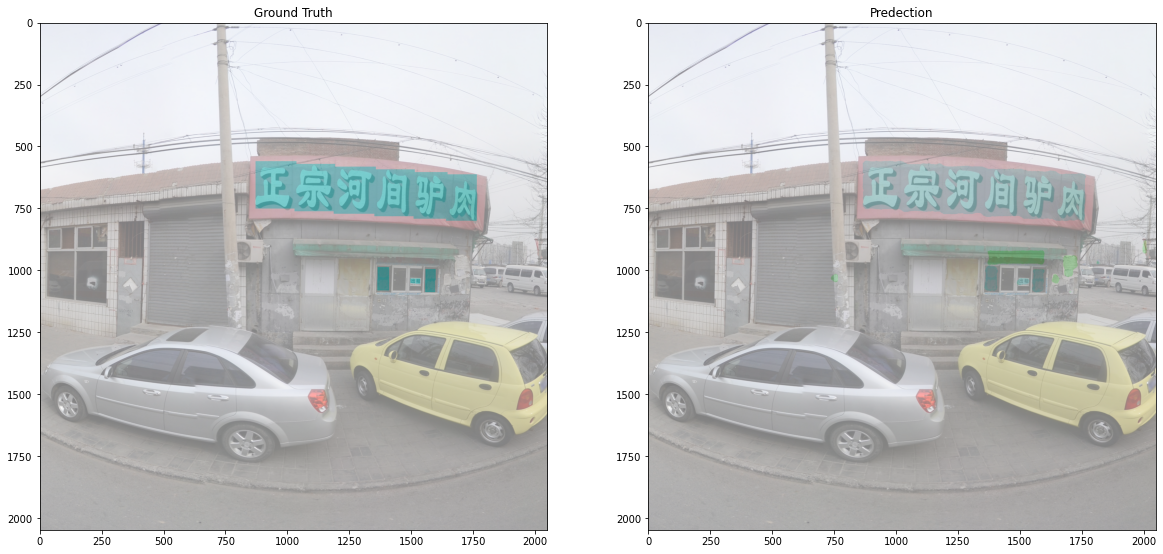

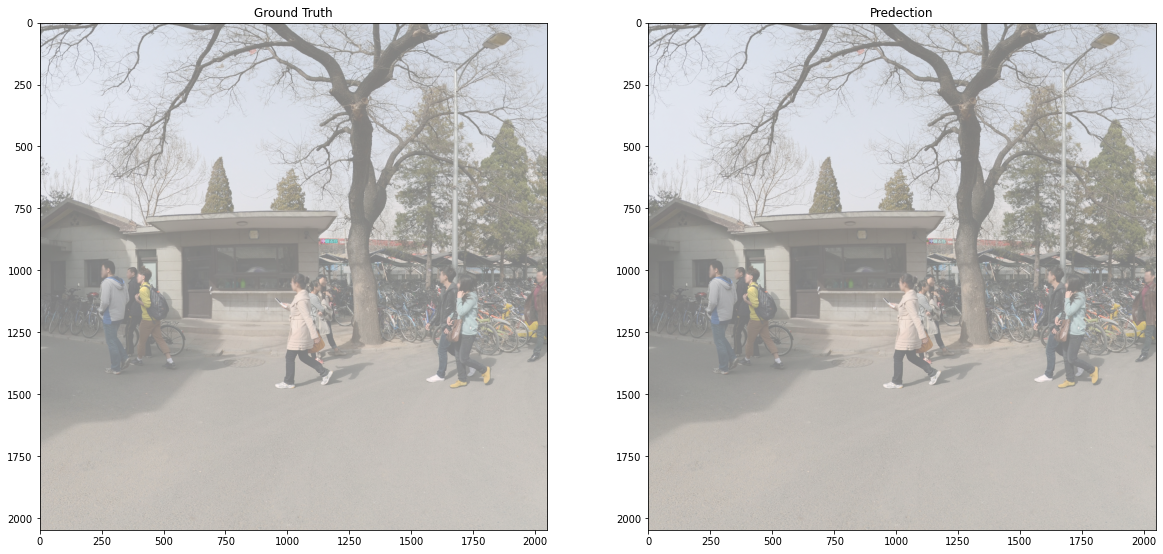

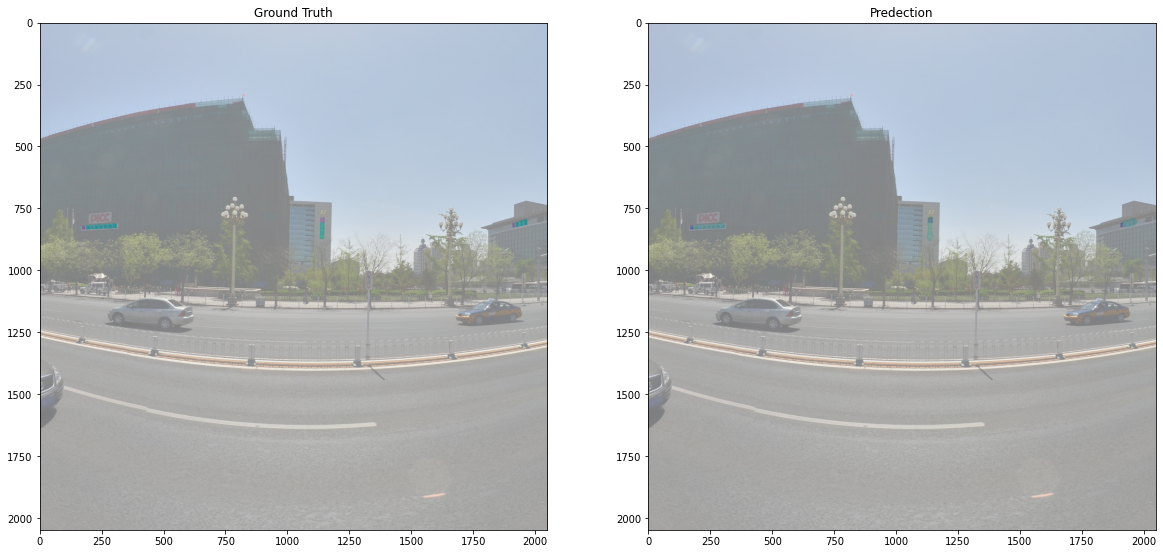

In [11]:
def plot_images(img_overay, preds_overay):
    # plot
    
    gs = gridspec.GridSpec(1, 2)
    f = plt.figure(figsize=(20, 20))

    ax1 = f.add_subplot(gs[0, 0])
    ax1.imshow(cv2.cvtColor(np.float32(img_overay / 255), cv2.COLOR_BGR2RGB))
    ax1.title.set_text('Ground Truth')

    ax2 = f.add_subplot(gs[0, 1])
    ax2.imshow(cv2.cvtColor(np.float32(preds_overay / 255), cv2.COLOR_BGR2RGB))
    ax2.title.set_text('Predection')


# get indecies of the highst f score
idx = f1_scores_np.argsort()[-4:][::-1]
ids = [idx[0], idx[3]]  # random choice
# get indecies of the lowest f score
idx = f1_scores_np.argsort()[:4]
ids += [idx[0], idx[2]]

for i in ids:
    # initialize labels
    ischinese_gt = np.zeros((2048, 2048, 3)) + 255
    ignore_gt = np.zeros((2048, 2048, 3)) + 255
    char_gt = np.zeros((2048, 2048, 3)) + 255
    ischinese_preds = np.zeros((2048, 2048, 3)) + 255
    ignore_preds = np.zeros((2048, 2048, 3)) + 255
    char_preds = np.zeros((2048, 2048, 3)) + 255

    # reformate
    image_bck = np.einsum("bchw->hwc", images_gt[i])[...,::-1]
    mask = labels_all[i].reshape(2048, 2048)
    preds = predections[i].reshape(2048, 2048)

    ischinese_gt_mask = (mask == 1)
    ignore_gt_mask = (mask == 2)
    char_gt_mask = (mask == 3)
    ischinese_preds_mask = (preds == 1)
    ignore_preds_mask = (preds == 2)
    char_preds_mask = (preds == 3)

    ischinese_gt[ischinese_gt_mask] = [255, 255, 0]
    ischinese_preds[ischinese_preds_mask] = [255, 255, 0]
    ignore_gt[ignore_gt_mask] = [0, 255, 0]
    ignore_preds[ignore_preds_mask] = [0, 255, 0]
    char_gt[char_gt_mask] = [255, 51, 153]
    char_preds[char_gt_mask] = [255, 51, 153]
    
    alpha = 0.5
    img_overay = np.uint8(image_bck*alpha + ischinese_gt*(1-alpha)*0.33 + ischinese_gt*(1-alpha)*0.33 + char_gt*(1-alpha)*0.34)
    preds_overay = np.uint8(image_bck*alpha + ischinese_preds*(1-alpha)*0.33 + ignore_preds*(1-alpha)*0.33 + char_preds*(1-alpha)*0.33)

    plot_images(img_overay, preds_overay)